# 機器學習專案三

## 資料說明及前處理

1.資料來源：TEJ資料庫

2.資料範圍：2008年-2020年本國銀行各項財務指標之各月總平均

3.採用指標：<br/>
(1)權益比率 Equity：表示銀行長期生存能力，低於5%代表有問題，越高越好<br/>
(2)資產報酬率 ROA：表示銀行獲利能力，越高越好<br/>
(3)存放比 LtoD：表示銀行流動性風險，正常值應小於100%，數值越高風險越高<br/>
(4)逾放比 NPL：表示銀行放款品質，3%以下表示授信品質好，數值越高放款品質越差<br/>
(5)備抵呆帳覆蓋率 Coverage：表示銀行承受呆帳能力，越高越好<br/>
(6)利息總收益比 NIM：表示銀行獲利能力，越高越好<br/>
(7)風險性 Risk：表示銀行承受風險的能力，越高越好<br/>

4.前處理：<br/>
(1)些許銀行資料量過少，因此決定以2020仍在營業的銀行作為觀察對象，捨棄大眾銀行、中華銀行、慶豐銀行、寶華銀行、澳盛台灣、樂天銀行。<br/>
(2)空值代表該銀行沒有提供該項服務，以0補值<br/>


## 共現性分析

(1)計算出各項指標之四分位數後，以四分位距作為分組依據<br/>
(2)橫軸欄位名稱以銀行代號命名，縱軸是四分位距，銀行的值落在該區間則標示1，其餘標示0

In [1]:
import pandas as pd
import numpy as np
import time
import requests
from tqdm import tqdm_notebook
import json
import statistics as stat
import multiprocessing as mp

In [2]:
# 讀取分組後資料
data = pd.read_csv('./../dataset/Bank_itemset_1.csv',na_values=['#VALUE!', '#DIV/0!'])
data.fillna(value=0, inplace=True)
data

,Bank,7,147,11,5,822,EROCTWTP,806,815,48,...,8,108,81,103,101,9,50,4,805,803
0,EquityQ1,0,1,0,1,0,0,0,0,0,...,1,1,0,1,0,0,1,0,0,0
1,EquityQ2,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,1
2,EquityQ3,0,0,0,0,0,0,1,1,0,...,0,0,1,0,1,1,0,0,0,0
3,EquityQ4,0,0,1,0,1,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,ROAQ1,0,0,0,0,0,0,0,1,0,...,0,0,0,0,1,0,1,1,0,0
5,ROAQ2,0,1,0,1,0,1,0,0,0,...,1,1,0,0,0,0,0,0,0,1
6,ROAQ3,1,0,0,0,0,0,1,0,1,...,0,0,0,1,0,1,0,0,1,0
7,ROAQ4,0,0,1,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
8,LtoDQ1,0,0,0,0,1,1,0,0,0,...,0,0,1,0,0,0,0,1,0,1
9,LtoDQ2,0,0,1,0,0,0,1,1,0,...,0,0,0,0,1,0,0,0,1,0


In [3]:
# 捨去不必要欄位
data = data.drop(['Bank'], axis=1)
data

,7,147,11,5,822,EROCTWTP,806,815,48,53,...,8,108,81,103,101,9,50,4,805,803
0,0,1,0,1,0,0,0,0,0,0,...,1,1,0,1,0,0,1,0,0,0
1,1,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,1,1
2,0,0,0,0,0,0,1,1,0,0,...,0,0,1,0,1,1,0,0,0,0
3,0,0,1,0,1,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,1,0,1,1,0,0
5,0,1,0,1,0,1,0,0,0,0,...,1,1,0,0,0,0,0,0,0,1
6,1,0,0,0,0,0,1,0,1,1,...,0,0,0,1,0,1,0,0,1,0
7,0,0,1,0,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
8,0,0,0,0,1,1,0,0,0,0,...,0,0,1,0,0,0,0,1,0,1
9,0,0,1,0,0,0,1,1,0,0,...,0,0,0,0,1,0,0,0,1,0


## make co-occurrence matrix

In [4]:
col = list(data.columns)
co_matrix_df = pd.DataFrame(columns=col)
co_matrix_weight = []
for index in tqdm_notebook(col):
    line_list = []
    for df_label in col:
        if index == df_label:
            line_list.append(0)
#             co_matrix_weight.append([index, df_label, 0])
        else:
            df1 = data[data[index] == 1]
            df1 = df1[df1[df_label] == 1]
            line_list.append(len(df1))
#             co_matrix_weight.append([index, df_label, len(df1)])
            if len(df1) >= 0:
                co_matrix_weight.append([index, df_label, len(df1)])
        
    co_matrix_df.loc[index] = line_list

In [5]:
co_matrix_df

,7,147,11,5,822,EROCTWTP,806,815,48,53,...,8,108,81,103,101,9,50,4,805,803
7,0,0,1,2,1,0,2,1,4,3,...,2,2,0,4,0,6,1,3,4,1
147,0,0,1,4,1,1,2,2,0,1,...,4,4,0,2,1,0,3,1,0,2
11,1,1,0,1,5,1,3,1,3,1,...,1,1,3,0,1,1,0,1,2,0
5,2,4,1,0,1,2,2,0,1,1,...,4,2,1,2,2,2,2,0,0,2
822,1,1,5,1,0,3,3,0,2,1,...,1,0,3,0,1,1,0,2,0,2
EROCTWTP,0,1,1,2,3,0,1,1,1,1,...,1,1,2,0,2,0,2,2,0,3
806,2,2,3,2,3,1,0,2,2,1,...,1,0,1,1,4,3,0,1,2,2
815,1,2,1,0,0,1,2,0,0,0,...,0,2,1,1,3,2,4,4,2,0
48,4,0,3,1,2,1,2,0,0,1,...,1,2,2,2,1,4,1,1,3,1
53,3,1,1,1,1,1,1,0,1,0,...,3,1,1,4,0,2,1,1,3,2


In [6]:
# 創造矩陣的方法二
df_asint = data.astype(int)
co_matrix_df2 = df_asint.T.dot(df_asint)

In [7]:
# 畫熱力圖
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,10))
sns.heatmap(co_matrix_df2,mask=co_matrix_df < 1,cmap='GnBu')
plt.title('bank', size = 14)
plt.suptitle('feature heat map',x = 0.435,y=0.95, fontsize=18)

Text(0.435, 0.95, 'feature heat map')

## co-occurrence graph

In [8]:
from matplotlib import pyplot as plt
import networkx as nx

/Users/huangshilun/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


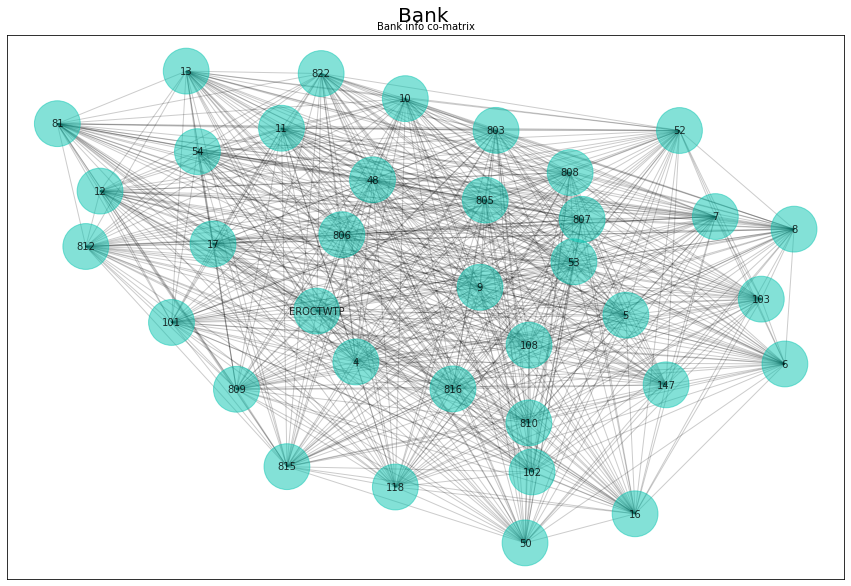

In [9]:
plt.figure(figsize=(15,10))
plt.rcParams['font.sans-serif'] = ['SimHei']   
plt.rcParams['font.family']='sans-serif'
g = nx.Graph()

g.add_weighted_edges_from(co_matrix_weight)
pos=nx.spring_layout(g)
nx.draw_networkx_nodes(g, pos, alpha=0.5,node_size=[val*60 for (node, val) in g.degree()], node_color='#08c5b1')
nx.draw_networkx_edges(g, pos, alpha=0.2)

nx.draw_networkx_labels(g, pos, font_size = 10, font_family='sans-serif', alpha=0.8)
plt.title('Bank info co-matrix', size = 10)
plt.suptitle('Bank',x = 0.51,y=0.92, fontsize=20)
plt.show()

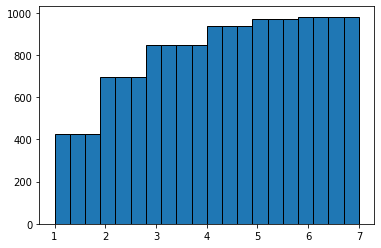

In [10]:
# 次數累積直方圖->找threshold

original_data = co_matrix_df.values.flatten()
#condition
count = [i for i in original_data if i > 0]
_, axs=plt.subplots()
#condition: cumulative = -1 if all i in data > 0; otherwise, cumulative = 1
axs.hist(count, bins = 20, cumulative = 1, edgecolor='black')
# axs.yaxis.set_major_formatter(matplotlib.ticker.PercentFormatter(xmax=1))
plt.show()

In [11]:
#顯示權重5以上的銀行
co_matrix_weight_n = []
for each in co_matrix_weight:
    if each[2] > 5:
        co_matrix_weight_n.append(each)

In [12]:
edges = g.edges()
weights = [g[u][v]['weight'] for u,v in edges]

n_weights = []
for i in weights:
    n_weights.append((i-min(weights))/(max(weights)-min(weights)))

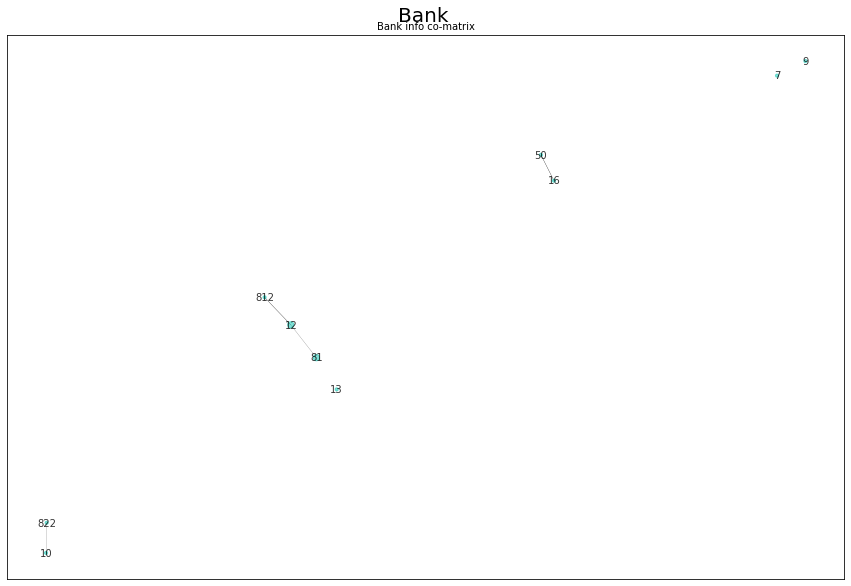

In [13]:
plt.figure(figsize=(15,10))
plt.rcParams['font.sans-serif'] = ['SimHei']   
plt.rcParams['font.family']='sans-serif'
g = nx.Graph()
g.add_weighted_edges_from(co_matrix_weight_n)
pos=nx.spring_layout(g)
nx.draw_networkx_nodes(g, pos, alpha=0.5,node_size=[val**2*10 for (node, val) in g.degree()], node_color='#08c5b1')
nx.draw_networkx_edges(g, pos, width=n_weights, alpha=1)

nx.draw_networkx_labels(g, pos, font_size = 10, font_family='sans-serif', alpha=0.8)
plt.title('Bank info co-matrix', size = 10)
plt.suptitle('Bank',x = 0.51,y=0.92, fontsize=20)

plt.show()

## 小結

由以上網路圖顯示： 

822-010（中信銀-花旗台灣）

007-009（三信銀-彰銀）

013-081-012-812（國泰世華-匯豐台灣-台新銀）

016-050（高雄銀-臺企銀）

彼此間在各項財務表現上有關聯性

## Apriori及關聯規則

In [14]:
df = pd.read_csv('./../dataset/bank_itemsets_0618.csv',na_values=['#VALUE!', '#DIV/0!'])
df = df.drop(['itemset'], axis=1)

df

,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9
0,元大銀,日盛銀行,台北富邦銀,台新銀,永豐銀行,兆豐商銀,匯豐台灣,瑞興銀,彰銀
1,上海商銀,中信銀,中輸銀,王道銀行,安泰銀,京城銀,花旗台灣,星展台灣,凱基銀行
2,一銀,元大銀,王道銀行,台中銀,玉山銀,安泰銀,新光銀行,彰銀,遠東銀
3,上海商銀,中信銀,台北富邦銀,台新銀,兆豐商銀,京城銀,花旗台灣,國泰世華,匯豐台灣
4,中信銀,中輸銀,花旗台灣,國泰世華,凱基銀行,渣打銀行,匯豐台灣,臺銀,聯邦銀
5,上海商銀,元大銀,日盛銀行,永豐銀行,玉山銀,安泰銀,板信銀,瑞興銀,遠東銀
6,土銀,中輸銀,台北富邦銀,台新銀,玉山銀,兆豐商銀,國泰世華,匯豐台灣,瑞興銀
7,一銀,上海商銀,中信銀,元大銀,王道銀行,永豐銀行,京城銀,彰銀,臺銀
8,三信銀行,上海商銀,土銀,中信銀,元大銀,玉山銀,花旗台灣,渣打銀行,華銀
9,王道銀行,台北富邦銀,台新銀,兆豐商銀,京城銀,國泰世華,匯豐台灣,瑞興銀,聯邦銀


In [15]:
# 轉成list of list
apr_list = df.values.tolist()
apr_list

[['元大銀', '日盛銀行', '台北富邦銀', '台新銀', '永豐銀行', '兆豐商銀', '匯豐台灣', '瑞興銀', '彰銀'],
 ['上海商銀', '中信銀', '中輸銀', '王道銀行', '安泰銀', '京城銀', '花旗台灣', '星展台灣', '凱基銀行'],
 ['一銀', '元大銀', '王道銀行', '台中銀', '玉山銀', '安泰銀', '新光銀行', '彰銀', '遠東銀'],
 ['上海商銀', '中信銀', '台北富邦銀', '台新銀', '兆豐商銀', '京城銀', '花旗台灣', '國泰世華', '匯豐台灣'],
 ['中信銀', '中輸銀', '花旗台灣', '國泰世華', '凱基銀行', '渣打銀行', '匯豐台灣', '臺銀', '聯邦銀'],
 ['上海商銀', '元大銀', '日盛銀行', '永豐銀行', '玉山銀', '安泰銀', '板信銀', '瑞興銀', '遠東銀'],
 ['土銀', '中輸銀', '台北富邦銀', '台新銀', '玉山銀', '兆豐商銀', '國泰世華', '匯豐台灣', '瑞興銀'],
 ['一銀', '上海商銀', '中信銀', '元大銀', '王道銀行', '永豐銀行', '京城銀', '彰銀', '臺銀'],
 ['三信銀行', '上海商銀', '土銀', '中信銀', '元大銀', '玉山銀', '花旗台灣', '渣打銀行', '華銀'],
 ['王道銀行', '台北富邦銀', '台新銀', '兆豐商銀', '京城銀', '國泰世華', '匯豐台灣', '瑞興銀', '聯邦銀'],
 ['一銀', '土銀', '台中銀', '永豐銀行', '合庫', '渣打銀行', '華銀', '新光銀行', '彰銀'],
 ['三信銀行', '日盛銀行', '玉山銀', '安泰銀', '星展台灣', '高雄銀', '華泰銀行', '臺企銀', '臺銀'],
 ['一銀', '王道銀行', '玉山銀', '安泰銀', '華銀', '陽信銀', '新光銀行', '彰銀', '遠東銀'],
 ['上海商銀', '中信銀', '台中銀', '台北富邦銀', '台新銀', '京城銀', '花旗台灣', '國泰世華', '匯豐台灣']]

In [16]:
from mlxtend.preprocessing import TransactionEncoder

te = TransactionEncoder()
te_ary = te.fit(apr_list).transform(apr_list)

te_ary

array([[False, False, False, False, False, False,  True,  True, False,
         True, False,  True,  True, False, False, False, False,  True,
        False,  True, False, False,  True, False, False, False,  True,
        False, False, False, False, False, False, False, False, False],
       [False, False,  True,  True,  True,  True, False, False,  True,
        False, False, False, False, False, False, False,  True, False,
        False, False,  True, False, False, False, False,  True, False,
        False, False, False,  True, False, False, False, False, False],
       [ True, False, False, False, False, False,  True, False, False,
        False,  True, False, False, False, False, False,  True,  True,
         True, False, False, False, False, False,  True,  True, False,
        False, False, False, False, False, False,  True, False, False],
       [False, False,  True,  True, False,  True, False,  True, False,
         True, False,  True,  True, False,  True, False, False, False,
   

In [17]:
te.columns_

['一銀',
 '三信銀行',
 '上海商銀',
 '中信銀',
 '中輸銀',
 '京城銀',
 '元大銀',
 '兆豐商銀',
 '凱基銀行',
 '匯豐台灣',
 '台中銀',
 '台北富邦銀',
 '台新銀',
 '合庫',
 '國泰世華',
 '土銀',
 '安泰銀',
 '彰銀',
 '新光銀行',
 '日盛銀行',
 '星展台灣',
 '板信銀',
 '永豐銀行',
 '渣打銀行',
 '玉山銀',
 '王道銀行',
 '瑞興銀',
 '聯邦銀',
 '臺企銀',
 '臺銀',
 '花旗台灣',
 '華泰銀行',
 '華銀',
 '遠東銀',
 '陽信銀',
 '高雄銀']

In [18]:
df = pd.DataFrame(te_ary, columns=te.columns_)
df

,一銀,三信銀行,上海商銀,中信銀,中輸銀,京城銀,元大銀,兆豐商銀,凱基銀行,匯豐台灣,...,瑞興銀,聯邦銀,臺企銀,臺銀,花旗台灣,華泰銀行,華銀,遠東銀,陽信銀,高雄銀
0,False,False,False,False,False,False,True,True,False,True,...,True,False,False,False,False,False,False,False,False,False
1,False,False,True,True,True,True,False,False,True,False,...,False,False,False,False,True,False,False,False,False,False
2,True,False,False,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,True,False,False
3,False,False,True,True,False,True,False,True,False,True,...,False,False,False,False,True,False,False,False,False,False
4,False,False,False,True,True,False,False,False,True,True,...,False,True,False,True,True,False,False,False,False,False
5,False,False,True,False,False,False,True,False,False,False,...,True,False,False,False,False,False,False,True,False,False
6,False,False,False,False,True,False,False,True,False,True,...,True,False,False,False,False,False,False,False,False,False
7,True,False,True,True,False,True,True,False,False,False,...,False,False,False,True,False,False,False,False,False,False
8,False,True,True,True,False,False,True,False,False,False,...,False,False,False,False,True,False,True,False,False,False
9,False,False,False,False,False,True,False,True,False,True,...,True,True,False,False,False,False,False,False,False,False


In [19]:
from mlxtend.frequent_patterns import apriori
fre_itemset = apriori(df, min_support=0.2,use_colnames=True) 
fre_itemset

,support,itemsets
0,0.285714,(一銀)
1,0.428571,(上海商銀)
2,0.428571,(中信銀)
3,0.214286,(中輸銀)
4,0.357143,(京城銀)
...,...,...
115,0.285714,"(台北富邦銀, 台新銀, 匯豐台灣, 國泰世華)"
116,0.214286,"(台北富邦銀, 台新銀, 匯豐台灣, 瑞興銀)"
117,0.214286,"(國泰世華, 台北富邦銀, 台新銀, 京城銀, 匯豐台灣)"
118,0.214286,"(國泰世華, 台北富邦銀, 台新銀, 匯豐台灣, 兆豐商銀)"


In [20]:
# 計算集合中的數量
fre_itemset['length'] = fre_itemset['itemsets'].apply(lambda x: len(x))

# 只顯示集合元素大於2
fre_itemset[fre_itemset['length'] > 1]

,support,itemsets,length
26,0.285714,"(一銀, 彰銀)",2
27,0.214286,"(一銀, 新光銀行)",2
28,0.214286,"(一銀, 王道銀行)",2
29,0.357143,"(上海商銀, 中信銀)",2
30,0.285714,"(上海商銀, 京城銀)",2
...,...,...,...
115,0.285714,"(台北富邦銀, 台新銀, 匯豐台灣, 國泰世華)",4
116,0.214286,"(台北富邦銀, 台新銀, 匯豐台灣, 瑞興銀)",4
117,0.214286,"(國泰世華, 台北富邦銀, 台新銀, 京城銀, 匯豐台灣)",5
118,0.214286,"(國泰世華, 台北富邦銀, 台新銀, 匯豐台灣, 兆豐商銀)",5


In [21]:
# 關聯規則表
from mlxtend.frequent_patterns import association_rules
final = association_rules(fre_itemset)

# 計算antecedents跟consequents數量
final['antecedent_len'] = final['antecedents'].apply(lambda x:len(x))
final['consequent_len'] = final['consequents'].apply(lambda x:len(x))

final

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,antecedent_len,consequent_len
0,(一銀),(彰銀),0.285714,0.357143,0.285714,1.000000,2.800000,0.183673,inf,1,1
1,(新光銀行),(一銀),0.214286,0.285714,0.214286,1.000000,3.500000,0.153061,inf,1,1
2,(上海商銀),(中信銀),0.428571,0.428571,0.357143,0.833333,1.944444,0.173469,3.428571,1,1
3,(中信銀),(上海商銀),0.428571,0.428571,0.357143,0.833333,1.944444,0.173469,3.428571,1,1
4,(花旗台灣),(中信銀),0.357143,0.428571,0.357143,1.000000,2.333333,0.204082,inf,1,1
...,...,...,...,...,...,...,...,...,...,...,...
197,"(匯豐台灣, 瑞興銀, 兆豐商銀)","(台北富邦銀, 台新銀)",0.214286,0.357143,0.214286,1.000000,2.800000,0.137755,inf,3,2
198,"(台北富邦銀, 瑞興銀)","(台新銀, 匯豐台灣, 兆豐商銀)",0.214286,0.285714,0.214286,1.000000,3.500000,0.153061,inf,2,3
199,"(台新銀, 瑞興銀)","(台北富邦銀, 匯豐台灣, 兆豐商銀)",0.214286,0.285714,0.214286,1.000000,3.500000,0.153061,inf,2,3
200,"(匯豐台灣, 瑞興銀)","(台北富邦銀, 台新銀, 兆豐商銀)",0.214286,0.285714,0.214286,1.000000,3.500000,0.153061,inf,2,3


In [22]:
#篩選
final[ (final['antecedent_len'] == 1) &
       (final['consequent_len'] == 1) &
       (final['confidence'] == 1) ]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,antecedent_len,consequent_len
0,(一銀),(彰銀),0.285714,0.357143,0.285714,1.0,2.800000,0.183673,inf,1,1
1,(新光銀行),(一銀),0.214286,0.285714,0.214286,1.0,3.500000,0.153061,inf,1,1
4,(花旗台灣),(中信銀),0.357143,0.428571,0.357143,1.0,2.333333,0.204082,inf,1,1
6,(兆豐商銀),(匯豐台灣),0.285714,0.428571,0.285714,1.0,2.333333,0.163265,inf,1,1
7,(兆豐商銀),(台北富邦銀),0.285714,0.357143,0.285714,1.0,2.800000,0.183673,inf,1,1
8,(兆豐商銀),(台新銀),0.285714,0.357143,0.285714,1.0,2.800000,0.183673,inf,1,1
9,(台北富邦銀),(匯豐台灣),0.357143,0.428571,0.357143,1.0,2.333333,0.204082,inf,1,1
11,(台新銀),(匯豐台灣),0.357143,0.428571,0.357143,1.0,2.333333,0.204082,inf,1,1
14,(國泰世華),(匯豐台灣),0.357143,0.428571,0.357143,1.0,2.333333,0.204082,inf,1,1
15,(台北富邦銀),(台新銀),0.357143,0.357143,0.357143,1.0,2.800000,0.229592,inf,1,1


## 小結

我們將關聯規則表的confidence值設定成1，以上表而言，可以舉例：當一銀在某項財務指標表現好的時候，彰銀的表現也會跟一銀一樣好
